In [1]:
!pip install idx2numpy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
import math 
import sys
import warnings
import idx2numpy
warnings.filterwarnings("ignore")

In [3]:
# 1.a.

X_train = idx2numpy.convert_from_file('/content/drive/MyDrive/Projects/SML_Assignment/Assignment_3/Saved_Data/train-images.idx3-ubyte')
X_test = idx2numpy.convert_from_file('/content/drive/MyDrive/Projects/SML_Assignment/Assignment_3/Saved_Data/t10k-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('/content/drive/MyDrive/Projects/SML_Assignment/Assignment_3/Saved_Data/train-labels.idx1-ubyte')
y_test = idx2numpy.convert_from_file('/content/drive/MyDrive/Projects/SML_Assignment/Assignment_3/Saved_Data/t10k-labels.idx1-ubyte')

print('Dataset Division : ')
print('Training X : ',X_train.shape)
print('Training y : ',y_train.shape)
print('Testing X : ',X_test.shape)
print('Testing y : ',y_test.shape)

Dataset Division : 
Training X :  (60000, 28, 28)
Training y :  (60000,)
Testing X :  (10000, 28, 28)
Testing y :  (10000,)


Classes :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


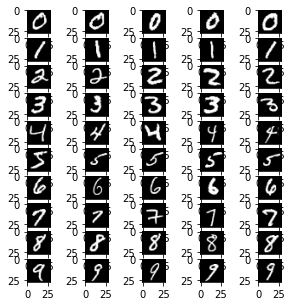

In [4]:
def Plot(X,y,c):
    p = list(np.unique(y))
    fig, ax = plt.subplots(nrows=len(p), ncols=c,figsize=(5,5))
    print('Classes : ',p)
    for i in range(len(p)):
        k = 0
        j = 0
        while(k<c and j<X.shape[0]):
            if(y[j]==p[i]):
                ax[i,k].imshow(X[j], cmap="gray") 
                k = k+1
            j=j+1
    plt.show()

Plot(X_train,y_train,c=5)            

In [5]:
# 1.b.

X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [6]:
def FDA(X,y):

  X_df = pd.DataFrame(X)
  col = X_df.columns
  X_df['Class'] = list(y)
  X_class = []

  temp= X_df.groupby('Class')
  for grp, d in temp:
    X_class.append(d[col].to_numpy())

  local_mean = []
  for i in range(len(X_class)):
    local_mean.append(np.mean(X_class[i],axis=0))

  global_mean = X[0]
  for i in range(1,X.shape[0]):
    global_mean = global_mean + X[i]
  global_mean = global_mean/X.shape[0]

  class_sc = []
  for i in range(len(X_class)):
    class_sc.append(np.dot((X_class[i]-local_mean[i]).T,(X_class[i]-local_mean[i])))
    
  class_scatter = class_sc[0]
  for i in range(1,len(X_class)):
      class_scatter  = class_scatter + class_sc[i]
  
  between_scatter = (X_class[0].shape[0]*np.dot((local_mean[0]-global_mean).reshape(X.shape[1],1),(local_mean[0]-global_mean).reshape(X.shape[1],1).T))
  for i in range(1,len(X_class)):
    t = (local_mean[i]-global_mean).reshape(X.shape[1],1)
    between_scatter = between_scatter + (float(X_class[i].shape[0])*np.dot(t,t.T))
  
  class_inv = np.linalg.pinv(class_scatter)
  final_mat = np.dot(between_scatter,class_inv)
  val, vec = linalg.eig(final_mat)
  
  # Sorting based on eigen values
  wval = val[val.argsort()[::-1]]
  vec = vec[:,val.argsort()[::-1]]
  wvec = vec[:,:len(X_class)-1]

  return wval , wvec

wval , wvec =  FDA(X_train,y_train)  


In [7]:
print('Shape of W from FDA : ',wvec.shape)

Shape of W from FDA :  (784, 9)


In [8]:
# 1.c.

Y = np.dot(wvec.T,X_train.T)
print('Shape of training X after projection : ',Y.shape)

Shape of training X after projection :  (9, 60000)


In [9]:
# 1.d.

Y = Y.T

In [16]:
def GetClasswiseStats(X,y):
  X_df = pd.DataFrame(X)
  col = X_df.columns
  X_df['Class'] = list(y)
  X_class = []
  
  class_mean = []
  class_cov = []
  Prior = []
  temp= X_df.groupby('Class')
  for grp, d in temp:
    X_class.append(d[col].to_numpy())
    Prior.append(d[col].to_numpy().shape[0]/X.shape[0])
  
  for i in range(len(X_class)):
    m = np.mean(X_class[i],axis=0)
    S = np.cov(X_class[i].T)
    class_mean.append(m)
    class_cov.append(S)

  return class_mean , class_cov , Prior


def Discriminant_Function(Data,class_mean,class_cov,Prior,nclass):
 
  y_pred = []
  for i in range(Data.shape[0]):
    t = []
    for j in range(nclass):
      Sinv = np.linalg.inv(class_cov[j])
      Sdet = np.linalg.det(class_cov[j])
      gc = np.dot(np.dot(Data[i],-0.5*Sinv),Data[i])
      gc = gc + np.dot(np.dot(Sinv,class_mean[j]),Data[i])
      gc = gc + (-0.5*np.dot(np.dot(class_mean[j],Sinv),class_mean[j])) \
           - 0.5*math.log(Sdet) + math.log(Prior[j])
      t.append(gc)
    y_pred.append(t.index(max(t)))

  return y_pred



In [17]:
class_mean , class_cov , Prior = GetClasswiseStats(Y,y_train)
Y_Test = np.dot(wvec.T,X_test.T)
Y_Test = Y_Test.T
y_pred = Discriminant_Function(Y_Test,class_mean,class_cov,Prior,nclass=10)
print('Predicted label for Testing X : ',np.array(y_pred))

Predicted label for Testing X :  [7 5 1 ... 4 5 6]


In [18]:
# 1.e.

def GetAccuracy(actual,predicted):  
  c = 0
  for i in range(len(actual)):
      if(actual[i]!=predicted[i]):
          continue
      else:    
          c = c + 1
  return c/len(actual)

In [19]:
print('Testing Accuracy : ',round(GetAccuracy(y_test,y_pred)*100,4),'%')

Testing Accuracy :  89.42 %
